In [19]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
from emodlib.malaria import IntrahostComponent
from naive_infection import configure_from_file, plot_timeseries

In [21]:
params = configure_from_file('config.yaml')

Isolating antibody-killing behavior by toggling:
- fever-killing (induced through cytokine production)
- merozoite-killing (assessed with IRBC rupture every 48h cycle) 

In [22]:
params['susceptibility_params'].update({'Fever_IRBC_Kill_Rate': 0})
params['infection_params'].update({'MSP1_Merozoite_Kill_Fraction': 0})
IntrahostComponent.configure(params)

In [23]:
def run_challenge(duration, dt=1):

    ts = np.arange(0, duration, dt)
    n_ts = len(ts)
    asexuals = np.zeros(n_ts)
    gametocytes = np.zeros(n_ts)

    ic = IntrahostComponent.create()
    ic.challenge()

    for i, t in enumerate(ts):
        # print('t = %f', t)
        ic.update(dt=dt)
        asexuals[i] = ic.parasite_density
        gametocytes[i] = ic.gametocyte_density

    return pd.DataFrame({'days': ts + dt,
                         'parasite_density': asexuals,
                         'gametocyte_density': gametocytes}).set_index('days')

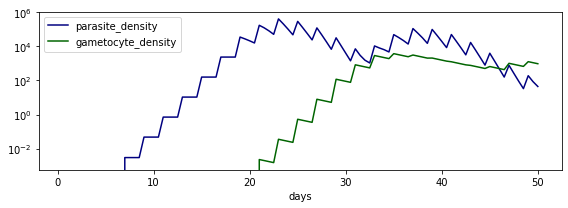

In [24]:
df_ts2 = run_challenge(duration=50, dt=0.5)
plot_timeseries(df_ts2)

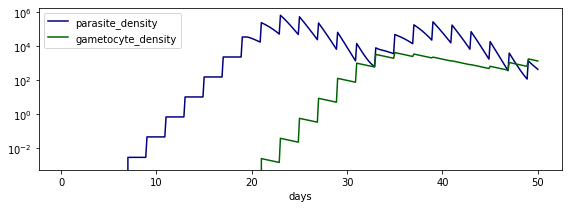

In [25]:
df_ts8 = run_challenge(duration=50, dt=0.125)
plot_timeseries(df_ts8)

You can see:
 - 48h cycle of infected red-blood cell (IRBC) rupture and multiplication of parasite density (steps up)
 - When the antibody killing starts to kick in and be evaluated on every time step (around day 19)
 - Note in the small-timestep example that the first decaying cycle actually has a steeper slope towards the end of that period, reflecting the transition across a sigmoidal killing vs. growing antibody concentration
 - Note also in the following cycle, the steeper decay in first small timestep, which I think may be the effect of higher cytokine killing immediately after ruptured IRBC in addition to the PfEMP1 antibody killing, which is applied at all small timesteps

In [26]:
def compare_timeseries(df1, df2):
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    df1.parasite_density.plot(ax=ax, color='r')
    df2.parasite_density.plot(ax=ax, color='navy')
    ax.set(yscale='log')
    fig.set_tight_layout(True)

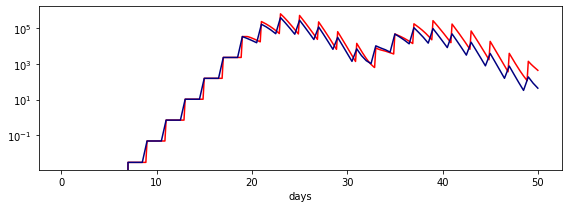

In [27]:
compare_timeseries(df_ts8, df_ts2)

**Note** that the random seeds for the two challenge trials are not synchronized, which means that the random draws of major/minor epitopes will not be in the same configuration.  As a consequence, the 2nd wave would be expected to vary substantially, not just because of different timestep approximations of exponential growth in antibody capacity above threshold, but also based on shared minor epitopes with first wave.